# Oppgave 4 Dataanalyse

In [117]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import plotly.express as px
from prettytable import PrettyTable
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool

In [126]:

client_id = "aff7c34e-993d-4132-81bc-1df3e81d7868" 
end_date = datetime.today().date()
start_date = end_date - timedelta(days=365)  
station_id = "SN18700"


Funksjonen fetch_and_analyze_weather henter værdata for en spesifisert stasjon og periode som kan velges i kodesnutten over. Den analyserer fire forskjellige værvariabler: temperatur, fuktighet, nedbør og vindhastighet. For hver variabel hentes gjennomsnitt, median og standardavvik for dataene, og eventuelle feil håndteres dersom det ikke er tilgjengelig data.
- Hentede data: For hver værvariabel (som definert i elements) gjør funksjonen et API-kall til MET.no sin Frost API for å hente data.
- Statistiske beregninger: For hver type værdata beregnes gjennomsnitt, median og standardavvik. Hvis data mangler, vises det som "Ingen data".
- Tabellformat: Resultatene vises i en tabell ved hjelp av PrettyTable, som gjør det lettere å visualisere og analysere de statistiske resultatene for hver variabel.

In [116]:
def fetch_and_analyze_weather(client_id, station_id, start_date, end_date):

    elements = [
        ("mean(air_temperature P1D)", "Temperatur", "°C"),
        ("mean(relative_humidity P1D)", "Fuktighet", "%"),
        ("sum(precipitation_amount P1D)", "Nedbør", "mm"),
        ("mean(wind_speed P1D)", "Vindhastighet", "m/s"),
    ]

    results = []

    for element_id, name, unit in elements:
        # Henter dataen fra API
        url = "https://frost.met.no/observations/v0.jsonld"
        params = {
            "sources": station_id,
            "elements": element_id,
            "referencetime": f"{start_date}/{end_date}"
        }

        try:
            response = requests.get(url, params=params, auth=(client_id, ""), timeout=10)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Feil ved henting av {name}: {e}")
            results.append((name, unit, "Feil", "Feil", "Feil"))
            continue

        data = response.json()
        values = []

        # Trekker ut verdier
        for obs in data.get("data", []):
            for el in obs.get("observations", []):
                if el["elementId"] == element_id and "value" in el:
                    values.append(el["value"])

        if values:
            mean_val = round(np.mean(values), 2)
            median_val = round(np.median(values), 2)
            std_val = round(np.std(values), 2)
        else:
            mean_val = median_val = std_val = "Ingen data"

        results.append((name, unit, mean_val, median_val, std_val))

    # Lager en fin tabell
    table = PrettyTable()
    table.field_names = ["Element", "Enhet", "Gjennomsnitt", "Median", "Std.avvik"]
    for row in results:
        table.add_row(row)

    print(table)

fetch_and_analyze_weather(client_id, station_id, start_date, end_date)

+---------------+-------+--------------+--------+-----------+
|    Element    | Enhet | Gjennomsnitt | Median | Std.avvik |
+---------------+-------+--------------+--------+-----------+
|   Temperatur  |   °C  |     8.29     |  8.3   |    7.48   |
|   Fuktighet   |   %   |    77.83     |  79.0  |   15.63   |
|     Nedbør    |   mm  |     2.49     |  0.0   |    5.56   |
| Vindhastighet |  m/s  |     2.42     |  2.3   |    1.0    |
+---------------+-------+--------------+--------+-----------+


# Oppgave 5 Visualisering

Funksjonen fetch_weather_data henter værdata fra MET.no sin Frost API for en spesifisert stasjon og tidsperiode. Den tar en liste av elementer (værvariabler) som parameter, og lager et API-kall med disse.
- API-kall: Bruker requests for å sende et GET-kall til API-en med de spesifiserte parameterne.
- Feilhåndtering: Hvis det oppstår en HTTP-feil eller en annen type forespørselsfeil, håndteres disse ved å skrive ut en feilmelding, og funksjonen returnerer None ved feil.
- Returnering av data: Hvis API-kallet lykkes, returneres JSON-dataene som inneholder værinformasjonen.

In [134]:
def fetch_weather_data(client_id, station_id, start_date, end_date, elements):
    url = "https://frost.met.no/observations/v0.jsonld"
    params = {
        "sources": station_id,
        "elements": ",".join(elements),
        "referencetime": f"{start_date}/{end_date}"
    }

    try:
        response = requests.get(url, params=params, auth=(client_id, ""), timeout=10)
        response.raise_for_status()
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error: {http_err}")
        print("Response text:", response.text)
        return None
    except requests.exceptions.RequestException as err:
        print(f"Error fetching data: {err}")
        return None

    return response.json()
   

Funksjonen parse_weather_data tar inn API-responsen (data) og et element_id som parameter. Den søker gjennom værobservasjonene for det spesifikke elementet (som temperatur, vindhastighet, etc.) og trekker ut relevante data.
- Feilhåndtering: Hvis dataene ikke er tilgjengelige eller API-responsen er tom, returneres en tom DataFrame med en feilmelding.
- Dataforberedelse: Funksjonen konverterer datoene til datetime-format, sorterer dataene etter dato og returnerer en DataFrame med dato og verdi for det ønskede elementet.

In [136]:
def parse_weather_data(data, element_id):
    if not data or "data" not in data:
        print("No data returned from API.")
        return pd.DataFrame()

    observations = []
    for obs in data["data"]:
        for element in obs["observations"]:
            if element["elementId"] == element_id:
                observations.append({
                    "date": obs["referenceTime"],
                    "value": element["value"]
                })

    df = pd.DataFrame(observations)
    if df.empty:
        print("No data available for this element.")
        return df

    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")
    return df


Funksjonen plot_weather_data tar inn en DataFrame med værdata, navnet på elementet, stasjonsnavnet, start- og sluttdato, samt en enhet. Den bruker Plotly for å lage et linjediagram med tid (dato) på x-aksen og den målte verdien på y-aksen.
- Plot Layout: Tittelen på grafen inkluderer elementnavn, stasjon og datoperiode, og aksetitlene tilpasses automatisk.
- Hover-Info: Når brukeren holder musen over et punkt på grafen, vises dato og verdi med enheten.
- Feilhåndtering: Hvis DataFrame er tom, avsluttes funksjonen uten å lage plottet.

In [110]:
def plot_weather_data(df, element_name, station_name, start_date, end_date, unit=""):
    if df.empty:
        return

    fig = px.line(
        df,
        x="date",
        y="value",
        title=f"{element_name} – {station_name} ({start_date} til {end_date})",
        labels={"date": "Dato", "value": f"{element_name} ({unit})"},
        template="plotly_white"
    )

    fig.update_traces(
        mode="lines",
        hovertemplate="Dato: %{x|%Y-%m-%d}<br>Verdi: %{y:.1f} {unit}"
    )
    fig.update_layout(
        xaxis_title="Dato",
        yaxis_title=f"{element_name} ({unit})",
        hovermode="x unified",
        showlegend=False
    )

    fig.show()


Videre tar vi i bruk fetch_weather_data, parse_weather_data og plot_weather_data for å hente, prosessere og visualisere værdataene for tre forskjellige meteorologiske elementer: gjennomsnittlig temperatur, relativ fuktighet og vindhastighet. Til slutt, for å visualisere nedbør, benytter vi et barplot i stedet for en linjegraf. Dette gir en bedre fremstilling av nedbøren, ettersom nedbør typisk er akkumulert over tid og er mer egnet for å vises i form av separate søyler per dag. For nedbøren bruker vi funksjonen plot_weather_Barplot, som er tilpasset for denne typen visualisering.

In [111]:

element_id = "mean(air_temperature P1D)"
element_name = "Gjennomsnittlig temperatur"
unit = "C"

json_data = fetch_weather_data(client_id, station_id, start_date, end_date, [element_id])
df = parse_weather_data(json_data, element_id)
plot_weather_data(df, element_name, "Oslo - Blindern", start_date, end_date, unit)


In [112]:
element_id = "mean(relative_humidity P1D)"
element_name = "Relativ fuktighet"
unit = "%"

json_data = fetch_weather_data(client_id, station_id, start_date, end_date, [element_id])
df = parse_weather_data(json_data, element_id)
plot_weather_data(df, element_name, "Oslo - Blindern", start_date, end_date, unit)

In [113]:
element_id = "mean(wind_speed P1D)"
element_name = "Vindhastighet"
unit = "m/s"

json_data = fetch_weather_data(client_id, station_id, start_date, end_date, [element_id])
df = parse_weather_data(json_data, element_id)
plot_weather_data(df, element_name, "Oslo - Blindern", start_date, end_date, unit)

In [114]:
element_id = "sum(precipitation_amount P1D)"
element_name = "Nedbør"
unit = "mm"

def plot_weather_Barplot(df, element_name, station_name, start_date, end_date, unit=""):
    if df.empty:
        print("Ingen data å vise.")
        return

    fig = px.bar(
        df,
        x="date",
        y="value",
        title=f"{element_name} - {station_name} ({start_date} til {end_date})",
        labels={"date": "Dato", "value": f"{element_name} ({unit})"},
        template="plotly_white"
    )

    fig.update_traces(
        hovertemplate="Dato: %{x|%Y-%m-%d}<br>Verdi: %{y:.1f} {unit}"
    )
    fig.update_layout(
        xaxis_title="Dato",
        yaxis_title=f"{element_name} ({unit})",
        hovermode="x unified",
        showlegend=False
    )

    fig.show()

json_data = fetch_weather_data(client_id, station_id, start_date, end_date, [element_id])
df = parse_weather_data(json_data, element_id)
plot_weather_Barplot(df, element_name, "Oslo - Blindern", start_date, end_date, unit)

# Oppgave 6 Predictiv analyse

In [138]:
def fetch_hourly_data(client_id, station_id, start_date, end_date):
    url = "https://frost.met.no/observations/v0.jsonld"
    elements = ["air_temperature", "relative_humidity", "wind_speed"]
    
    params = {
        "sources": station_id,
        "elements": ",".join(elements),
        "referencetime": f"{start_date}/{end_date}",
        "timeresolutions": "PT1H",
        "timeoffsets": "default"
    }

    try:
        response = requests.get(url, params=params, auth=(client_id, ""), timeout=15)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Feil ved henting av timesdata: {e}")
        return pd.DataFrame()

    data = response.json().get("data", [])
    records = {}

    for item in data:
        time = pd.to_datetime(item["referenceTime"]).tz_localize(None)
        if time not in records:
            records[time] = {"date": time}

        for obs in item["observations"]:
            element_id = obs["elementId"]
            value = obs.get("value", None)
            records[time][element_id] = value

    df = pd.DataFrame.from_dict(records, orient="index")
    df = df.sort_values("date").reset_index(drop=True)
    
    return df

fetch_hourly_data(client_id, station_id, start_date, end_date)


,date,air_temperature,relative_humidity,wind_speed
0,2024-04-21 00:00:00,3.7,51,5.0
1,2024-04-21 01:00:00,2.8,53,4.4
2,2024-04-21 02:00:00,2.4,55,4.8
3,2024-04-21 03:00:00,2.0,57,5.4
4,2024-04-21 04:00:00,2.0,58,6.2
...,...,...,...,...
8755,2025-04-20 19:00:00,8.2,76,3.7
8756,2025-04-20 20:00:00,7.7,76,1.8
8757,2025-04-20 21:00:00,7.4,76,1.5
8758,2025-04-20 22:00:00,7.2,72,1.4


In [160]:
def prepare_weather_data(df):
    """Rens og forbered timesbasert værdata for analyse og modellering."""
    df = df.copy()
    
    # Konverter 'date' til datetime og sett som indeks for interpolasjon
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")

    # Logg og fyll inn manglende verdier for hver værvariabel
    for column in df.columns:
        missing = df[column].isna().sum()
        if missing > 0:
            print(f"Manglende verdier i '{column}': {missing}")
            df[column] = df[column].interpolate(method="time")
    
    # Sett tilbake 'date' som kolonne
    df = df.reset_index()

    return df

df_hourly = fetch_hourly_data(client_id, station_id, start_date, end_date)
df = prepare_weather_data(df_hourly)
print(df.head())


                 date  air_temperature  relative_humidity  wind_speed
0 2024-04-21 00:00:00              3.7                 51         5.0
1 2024-04-21 01:00:00              2.8                 53         4.4
2 2024-04-21 02:00:00              2.4                 55         4.8
3 2024-04-21 03:00:00              2.0                 57         5.4
4 2024-04-21 04:00:00              2.0                 58         6.2


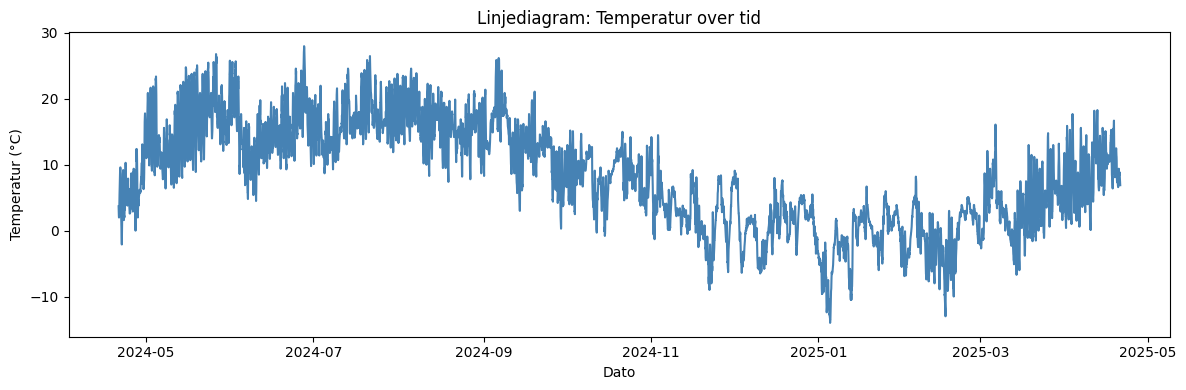

C:\Users\User\AppData\Local\Temp\ipykernel_12536\532420958.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




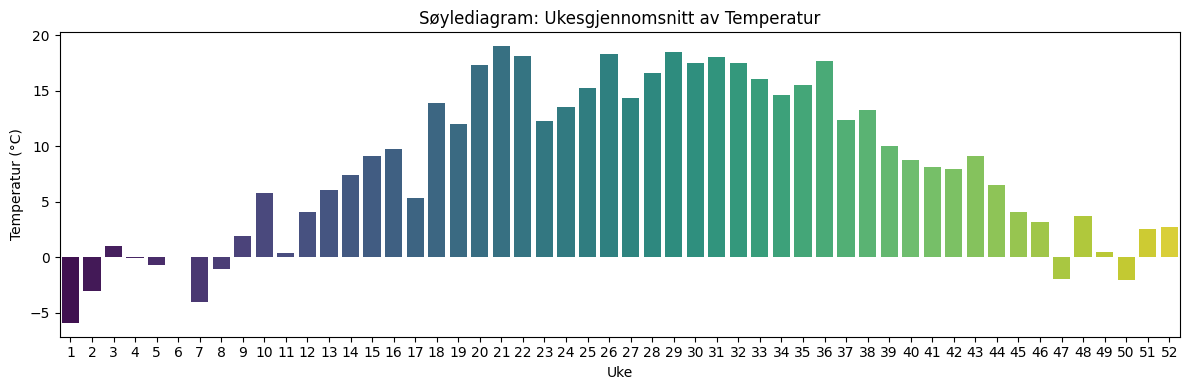

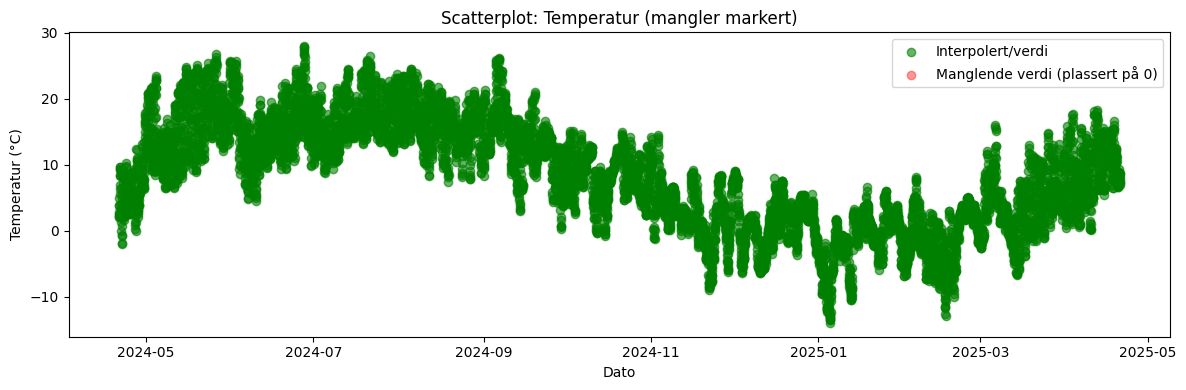

In [143]:
def plot_weather_trends(df, column, variable_name, unit):
    """Visualiser værdata (1 kolonne) med tre graf-typer og vis manglende verdier."""
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    
    # Sjekk at valgt kolonne finnes
    if column not in df.columns:
        print(f"Kolonnen '{column}' finnes ikke i datasettet.")
        return

    # 1. Linjediagram
    plt.figure(figsize=(12, 4))
    sns.lineplot(x="date", y=column, data=df, color="steelblue")
    plt.title(f"Linjediagram: {variable_name} over tid")
    plt.xlabel("Dato")
    plt.ylabel(f"{variable_name} ({unit})")
    plt.tight_layout()
    plt.show()

    # 2. Søylediagram – ukesgjennomsnitt
    df_bar = df.copy()
    df_bar["Uke"] = df_bar["date"].dt.isocalendar().week
    weekly_avg = df_bar.groupby("Uke")[column].mean().reset_index()

    plt.figure(figsize=(12, 4))
    sns.barplot(x="Uke", y=column, data=weekly_avg, palette="viridis")
    plt.title(f"Søylediagram: Ukesgjennomsnitt av {variable_name}")
    plt.xlabel("Uke")
    plt.ylabel(f"{variable_name} ({unit})")
    plt.tight_layout()
    plt.show()

    # 3. Scatterplot – vis manglende verdier (før interpolering)
    df_missing = df.copy()
    df_missing["raw"] = df_missing[column]
    df_missing["is_missing"] = df_missing["raw"].isna()

    plt.figure(figsize=(12, 4))
    plt.scatter(df["date"], df[column], label="Interpolert/verdi", color="green", alpha=0.6)
    plt.scatter(df_missing[df_missing["is_missing"]]["date"], 
                [0]*df_missing["is_missing"].sum(), 
                label="Manglende verdi (plassert på 0)", color="red", alpha=0.4)
    plt.title(f"Scatterplot: {variable_name} (mangler markert)")
    plt.xlabel("Dato")
    plt.ylabel(f"{variable_name} ({unit})")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_weather_trends(df, "air_temperature", "Temperatur", "°C")
#plot_weather_trends(df_cleaned, "wind_speed", "Vindhastighet", "m/s")
#plot_weather_trends(df_cleaned, "relative_humidity", "Relativ fuktighet", "%")


Evaluering på testdata:
MAE: 0.55
MSE: 0.64
R²: 0.98


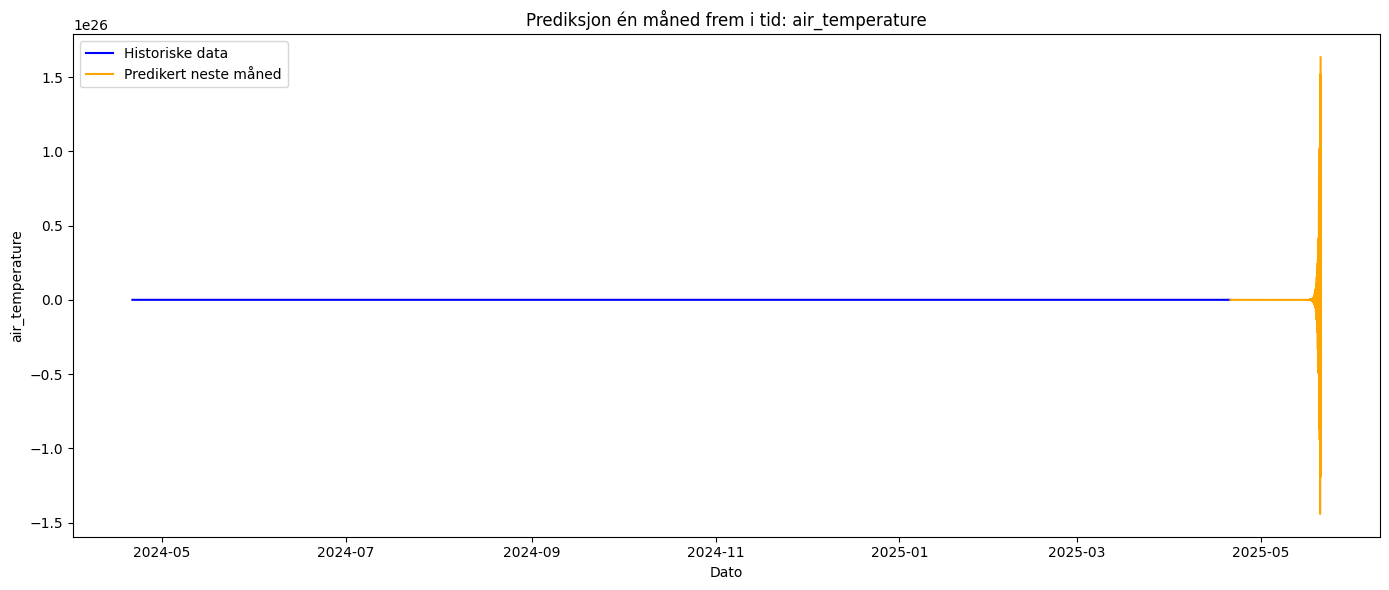

(LinearRegression(),
                    date  forecast_air_temperature
 0   2025-04-21 00:00:00              8.456834e+00
 1   2025-04-21 01:00:00              7.951554e+00
 2   2025-04-21 02:00:00              7.402358e+00
 3   2025-04-21 03:00:00              7.166400e+00
 4   2025-04-21 04:00:00              6.394126e+00
 ..                  ...                       ...
 715 2025-05-20 19:00:00             -1.441141e+26
 716 2025-05-20 20:00:00              1.517575e+26
 717 2025-05-20 21:00:00             -1.193840e+26
 718 2025-05-20 22:00:00             -4.208534e+24
 719 2025-05-20 23:00:00              1.633092e+26
 
 [720 rows x 2 columns])

In [161]:
def linear_regression(df, target_column, feature_lag_hours, forecast_hours):
    """
    Tren en lineær regresjonsmodell og bruk den til å predikere fremtidige verdier.
    """
    df = df.copy()

    # --- Rens og forbered data ---
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")  # Viktig for tidsserier

    if target_column not in df.columns:
        print(f"Kolonnen '{target_column}' finnes ikke.")
        return
    
    df = df[["date", target_column]].dropna()
    df[target_column] = pd.to_numeric(df[target_column], errors="coerce")
    df = df.dropna()

    for i in range(1, feature_lag_hours + 1):
        df[f"lag_{i}"] = df[target_column].shift(i)

    df.dropna(inplace=True)

    # Split features og target
    feature_cols = [f"lag_{i}" for i in range(1, feature_lag_hours + 1)]
    X = df[feature_cols]
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluering
    print("Evaluering på testdata:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"R²: {r2_score(y_test, y_pred):.2f}")

    #Fremtidig prediksjon
    future_preds = []
    last_known = df.iloc[-feature_lag_hours:][target_column].tolist()

    for _ in range(forecast_hours):
        input_features = pd.DataFrame([last_known[-feature_lag_hours:]], columns=feature_cols)
        pred = model.predict(input_features)[0]
        future_preds.append(pred)
        last_known.append(pred)

    # Lag fremtidige datoer
    last_date = df["date"].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=forecast_hours, freq="h")  # Bruk 'h'

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df[target_column], label="Historiske data", color="blue")
    plt.plot(future_dates, future_preds, label="Predikert neste måned", color="orange")
    plt.title(f"Prediksjon én måned frem i tid: {target_column}")
    plt.xlabel("Dato")
    plt.ylabel(target_column)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, pd.DataFrame({"date": future_dates, f"forecast_{target_column}": future_preds})



# Temperatur
linear_regression(df, target_column="air_temperature", feature_lag_hours=5, forecast_hours=24*30)
# Fuktighet
#linear_regression(df, target_column="relative_humidity", feature_lag_days=3)
# Vind
#linear_regression(df, target_column="wind_speed", feature_lag_days=4)



Evaluering på testdata:
MAE: 0.55
MSE: 0.64
R²: 0.98


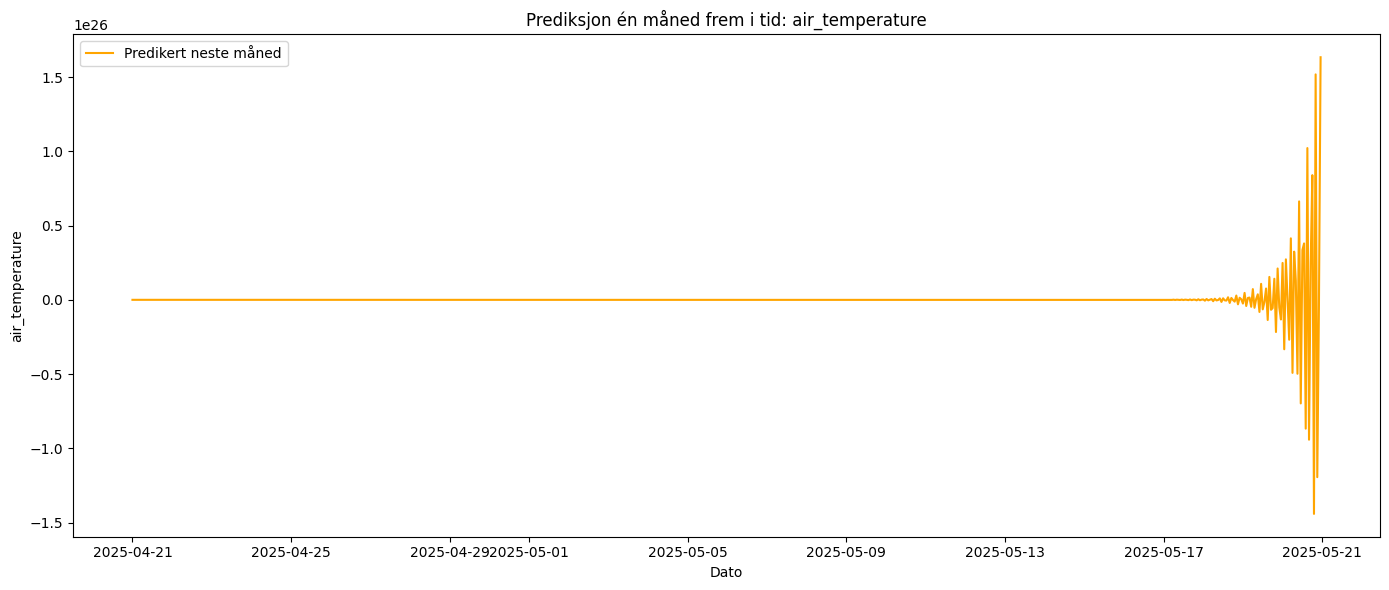

(LinearRegression(),
                    date  forecast_air_temperature
 0   2025-04-21 00:00:00              8.456834e+00
 1   2025-04-21 01:00:00              7.951554e+00
 2   2025-04-21 02:00:00              7.402358e+00
 3   2025-04-21 03:00:00              7.166400e+00
 4   2025-04-21 04:00:00              6.394126e+00
 ..                  ...                       ...
 715 2025-05-20 19:00:00             -1.441141e+26
 716 2025-05-20 20:00:00              1.517575e+26
 717 2025-05-20 21:00:00             -1.193840e+26
 718 2025-05-20 22:00:00             -4.208534e+24
 719 2025-05-20 23:00:00              1.633092e+26
 
 [720 rows x 2 columns])

In [162]:
def linear_regression(df, target_column, feature_lag_hours, forecast_hours):
    """
    Tren en lineær regresjonsmodell og bruk den til å predikere fremtidige verdier.
    Plotter kun de predikerte verdiene.
    """
    df = df.copy()

    # --- Rens og forbered data ---
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")

    if target_column not in df.columns:
        print(f"Kolonnen '{target_column}' finnes ikke.")
        return
    
    df = df[["date", target_column]].dropna()
    df[target_column] = pd.to_numeric(df[target_column], errors="coerce")
    df = df.dropna()

    # Lag feature-lag
    for i in range(1, feature_lag_hours + 1):
        df[f"lag_{i}"] = df[target_column].shift(i)

    df.dropna(inplace=True)

    feature_cols = [f"lag_{i}" for i in range(1, feature_lag_hours + 1)]
    X = df[feature_cols]
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluering
    print("Evaluering på testdata:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"R²: {r2_score(y_test, y_pred):.2f}")

    # Prediksjon frem i tid
    future_preds = []
    last_known = df.iloc[-feature_lag_hours:][target_column].tolist()

    for _ in range(forecast_hours):
        input_features = pd.DataFrame([last_known[-feature_lag_hours:]], columns=feature_cols)
        pred = model.predict(input_features)[0]
        future_preds.append(pred)
        last_known.append(pred)

    last_date = df["date"].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=forecast_hours, freq="h")

    # Plot kun fremtidig prediksjon
    plt.figure(figsize=(14, 6))
    plt.plot(future_dates, future_preds, label="Predikert neste måned", color="orange")
    plt.title(f"Prediksjon én måned frem i tid: {target_column}")
    plt.xlabel("Dato")
    plt.ylabel(target_column)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, pd.DataFrame({"date": future_dates, f"forecast_{target_column}": future_preds})

# Temperatur
linear_regression(df, target_column="air_temperature", feature_lag_hours=5, forecast_hours=24*30)


Evaluering for air_temperature:
MAE: 0.55
MSE: 0.64
R²: 0.98

Evaluering for relative_humidity:
MAE: 2.96
MSE: 19.08
R²: 0.95

Evaluering for wind_speed:
MAE: 0.66
MSE: 0.81
R²: 0.63


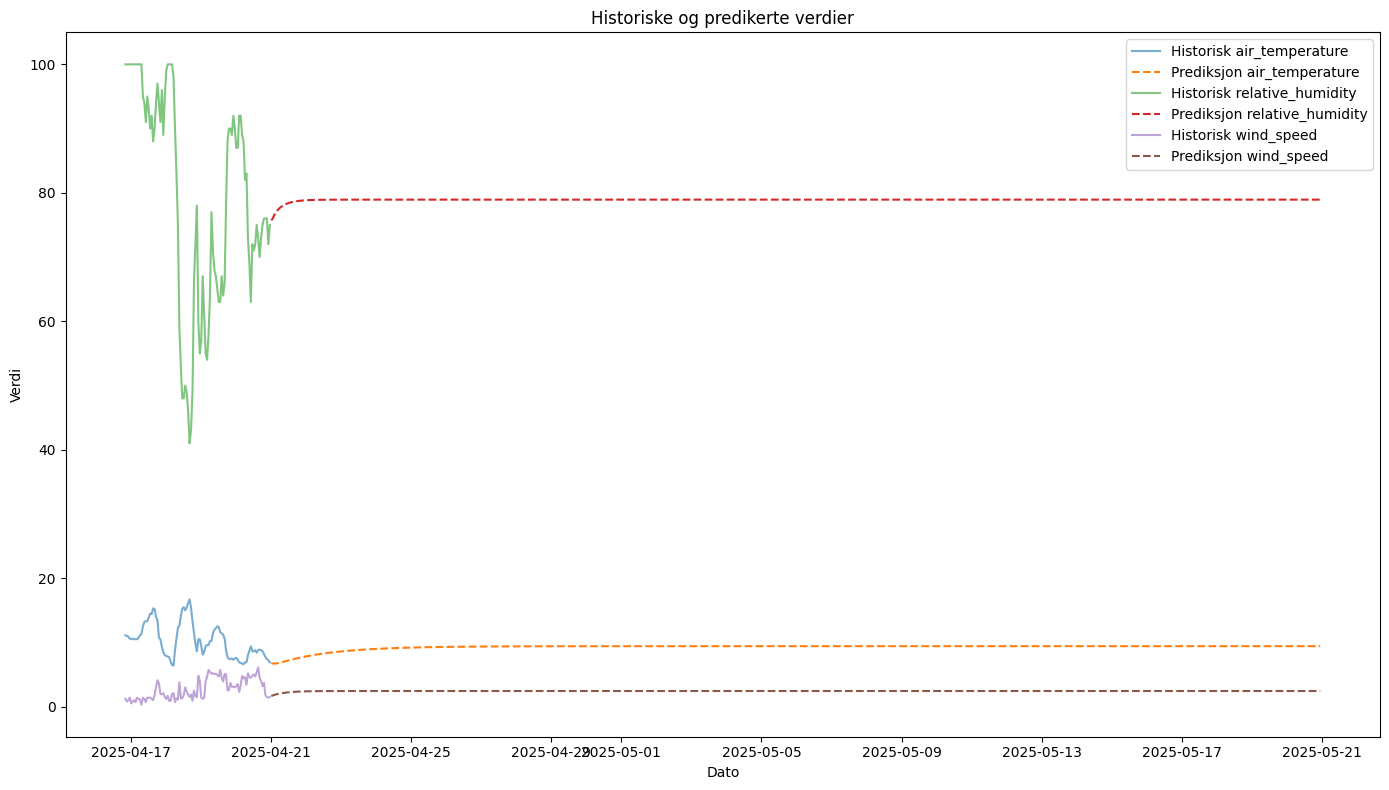

In [164]:
def linear_regression_multivariate(df, target_columns, feature_lag_hours, forecast_hours):
    """
    Tren lineær regresjonsmodell for flere målvariabler og prediker fremtidige verdier.
    Plotter historiske og predikerte verdier for hver målvariabel.
    
    Parameters:
    - df: DataFrame med 'date' og målkolonner.
    - target_columns: Liste med kolonnenavn for målvariabler (f.eks. ['air_temperature', 'relative_humidity']).
    - feature_lag_hours: Antall timer med lagde features.
    - forecast_hours: Antall timer å predikere frem i tid.
    
    Returns:
    - models: Ordbok med trente modeller for hver målvariabel.
    - forecasts: DataFrame med predikerte verdier.
    """
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").set_index("date")

    # Sjekk om målkolonner finnes
    missing_cols = [col for col in target_columns if col not in df.columns]
    if missing_cols:
        print(f"Følgende kolonner finnes ikke i DataFrame: {missing_cols}")
        return None, None

    # Konverter til numerisk og fjern NaN
    for col in target_columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna()

    # Lag features (lag) for hver målvariabel
    for col in target_columns:
        for i in range(1, feature_lag_hours + 1):
            df[f"{col}_lag_{i}"] = df[col].shift(i)
    df = df.dropna()

    # Forbered modeller og prediksjoner
    models = {}
    forecasts = pd.DataFrame(index=pd.date_range(start=df.index.max() + pd.Timedelta(hours=1), 
                                                periods=forecast_hours, freq="h"))
    
    for target in target_columns:
        feature_cols = [f"{target}_lag_{i}" for i in range(1, feature_lag_hours + 1)]
        X = df[feature_cols]
        y = df[target]

        # Del data i trenings- og testsett
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        # Tren modell
        model = LinearRegression()
        model.fit(X_train, y_train)
        models[target] = model

        # Evaluer modell
        y_pred = model.predict(X_test)
        print(f"\nEvaluering for {target}:")
        print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
        print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
        print(f"R²: {r2_score(y_test, y_pred):.2f}")

        # Prediksjon frem i tid
        future_preds = []
        last_known = df[target].tail(feature_lag_hours).tolist()[::-1]  # Siste kjente verdier, reversert

        for _ in range(forecast_hours):
            input_features = pd.DataFrame([last_known], columns=feature_cols)
            pred = model.predict(input_features)[0]
            future_preds.append(pred)
            last_known = [pred] + last_known[:-1]  # Oppdater med ny prediksjon

        forecasts[f"forecast_{target}"] = future_preds

    # Plotting
    plt.figure(figsize=(14, 8))
    for target in target_columns:
        # Plot historiske data (siste 100 timer for kontekst)
        plt.plot(df.index[-100:], df[target][-100:], label=f"Historisk {target}", alpha=0.6)
        # Plot prediksjoner
        plt.plot(forecasts.index, forecasts[f"forecast_{target}"], label=f"Prediksjon {target}", linestyle="--")
    
    plt.title("Historiske og predikerte verdier")
    plt.xlabel("Dato")
    plt.ylabel("Verdi")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Legg til dato som kolonne i forecasts
    forecasts = forecasts.reset_index().rename(columns={"index": "date"})
    return models, forecasts

models, forecasts = linear_regression_multivariate(
    df=df,
    target_columns=["air_temperature", "relative_humidity", "wind_speed"],
    feature_lag_hours=5,
    forecast_hours=24*30  # En måned frem i tid
)

In [154]:
def plot_with_bokeh(df, variable_name="Temperatur", unit="C"):
    """Interaktiv linjegraf med Bokeh."""
    from bokeh.models import ColumnDataSource
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    
    source = ColumnDataSource(df)

    p = figure(title=f"{variable_name} over tid", x_axis_type="datetime", width=800, height=300)
    p.line("date", "value", source=source, line_width=2, color="navy", legend_label=variable_name)
    p.add_tools(HoverTool(tooltips=[("Dato", "@date{%F}"), (f"{variable_name}", "@value{0.2f}")],
                          formatters={'@date': 'datetime'}))

    p.xaxis.axis_label = "Dato"
    p.yaxis.axis_label = f"{variable_name} ({unit})"
    p.legend.location = "top_left"
    show(p)

plot_with_bokeh(df, variable_name="Temperatur", unit="C")

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : y='value' [no close matches] {renderer: GlyphRenderer(id='p1059', ...)}
